In [1]:
using Test
using StaticArrays, Plots

using Dionysos
const DI = Dionysos
const UT = DI.Utils
const DO = DI.Domain
const ST = DI.System
const SY = DI.Symbolic
const OP = DI.Optim
const AB = OP.Abstraction

include(joinpath(dirname(dirname(pathof(Dionysos))), "problems/pendulum", "pendulum.jl"))

concrete_problem = Pendulum.problem(; objective = "safety-up")
concrete_system = concrete_problem.system

x0 = SVector(0.0, 0.0)
hx = SVector(0.05, 0.05)
state_grid = DO.GridFree(x0, hx)

u0 = SVector(0.0);
h = SVector(0.3);
input_grid = DO.GridFree(u0, h);

using JuMP
optimizer = MOI.instantiate(AB.UniformGridAbstraction.Optimizer)
MOI.set(optimizer, MOI.RawOptimizerAttribute("concrete_problem"), concrete_problem)
MOI.set(optimizer, MOI.RawOptimizerAttribute("state_grid"), state_grid)
MOI.set(optimizer, MOI.RawOptimizerAttribute("input_grid"), input_grid)
MOI.optimize!(optimizer)

abstract_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_controller"))
concrete_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("concrete_controller"))

compute_symmodel_from_controlsystem! started
compute_symmodel_from_controlsystem! terminated with success: 9050343 transitions created
  1.008838 seconds (78 allocations: 220.178 MiB)
compute_controller_safe! started

compute_controller_safe! terminated without covering init set


(::Dionysos.Optim.Abstraction.UniformGridAbstraction.var"#concrete_controller#10"{Dionysos.Optim.Abstraction.UniformGridAbstraction.var"#concrete_controller#9#11"{Dionysos.Symbolic.SymbolicModelList{2, 1, Dionysos.Domain.DomainList{2, Float64, Dionysos.Domain.GridFree{2, Float64}}, Dionysos.Domain.DomainList{1, Float64, Dionysos.Domain.GridFree{1, Float64}}, Dionysos.Symbolic.AutomatonList{Dionysos.Utils.SortedTupleSet{3, Tuple{Int64, Int64, Int64}}}}, Dionysos.Utils.SortedTupleSet{2, Tuple{Int64, Int64}}}}) (generic function with 1 method)

### Trajectory display

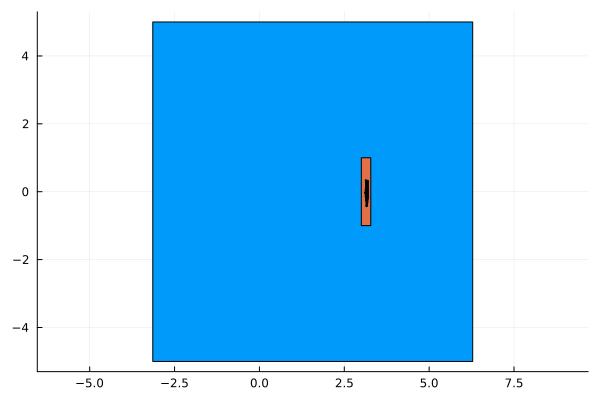

In [2]:
nstep = 100
x0 = SVector(UT.sample(concrete_problem.initial_set)...)

control_trajectory =
    ST.get_closed_loop_trajectory(concrete_system.f, concrete_controller, x0, nstep)

fig = plot(; aspect_ratio = :equal);
plot!(concrete_system.X);
plot!(concrete_problem.safe_set; markersize = 1, arrows = false)
plot!(control_trajectory; markersize = 1, arrows = false)
display(fig)

### For Visualization

In [3]:
using RigidBodyDynamics, MeshCatMechanisms
urdf = joinpath(dirname(dirname(pathof(Dionysos))), "problems/pendulum/", "Pendulum.urdf")
mechanism = parse_urdf(urdf)
state = MechanismState(mechanism)
joint = first(joints(mechanism))

tstep = 0.1
state_values =
    [ST.get_state(control_trajectory, i)[1] for i in 1:ST.length(control_trajectory)]
ts = collect(0.0:tstep:((length(state_values) - 1) * tstep))
qs = Vector{Vector{Float64}}(undef, length(state_values))
for i in 1:length(state_values)
    set_configuration!(state, joint, state_values[i])
    qs[i] = configuration(state)
end
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
MeshCatMechanisms.setanimation!(mvis, ts, qs)

[ Info: Listening on: 127.0.0.1:8701, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*